In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [68]:
train_df = pd.read_csv('../../../data/FIFA/FIFA_train.csv')
test_df = pd.read_csv('../../../data/FIFA/FIFA_test.csv')

In [69]:
print(train_df.isna().sum().sum())
print(test_df.isna().sum().sum())

0
0


In [70]:
train_df.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


### 필요없는 컬럼 삭제

In [6]:
train_df.drop(['id', 'name'], axis=1, inplace=True)
test_df.drop(['id', 'name'], axis=1, inplace=True)

### Object 데이터 확인

In [7]:
print(train_df['continent'].value_counts())
print('################################')
print(train_df['contract_until'].value_counts())
print('################################')
print(train_df['position'].value_counts())
print('################################')
print(train_df['prefer_foot'].value_counts())

europe           5322
south america    1927
asia              787
africa            721
oceania           175
Name: continent, dtype: int64
################################
2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64
################################
MF    3428
DF    2791
ST    1705
GK    1008
Name: position, dtype: int64
################################
right    6837
left     2095
Name: prefer_foot, dtype: int64


### contract_until 데이터 통일

In [8]:
train_df['contract_until'] = train_df['contract_until'].map(lambda x : x[-4:] if len(x) > 4 else x[:])
train_df['contract_until'] = train_df['contract_until'].astype('int64')
train_df['contract_until'].value_counts()

test_df['contract_until'] = test_df['contract_until'].map(lambda x : x[-4:] if len(x) > 4 else x[:])
test_df['contract_until'] = test_df['contract_until'].astype('int64')
test_df['contract_until'].value_counts()

2019    1171
2021     985
2020     887
2022     338
2023     251
2018     189
2025       4
2024       2
2026       1
Name: contract_until, dtype: int64

### Object 컬럼 데이터 One-hot encoding

In [9]:
train_df['age'].unique()

array([31, 27, 32, 25, 26, 29, 33, 30, 40, 24, 28, 34, 23, 22, 35, 36, 21,
       18, 19, 37, 20, 39, 17, 38, 16], dtype=int64)

In [10]:
def cat_age(x):
    if x < 20: x = 'Early'
    elif x < 30 : x = 'Mid'
    else: x = 'Old'
    return x

In [11]:
train_df['age'] = train_df['age'].apply(cat_age)
test_df['age'] = test_df['age'].apply(cat_age)

In [12]:
train_df['contract_until'].unique()

array([2021, 2020, 2019, 2023, 2022, 2024, 2026, 2018, 2025], dtype=int64)

In [13]:
def cat_contract(x):
    if x <= 2020: x = 'contract_3'
    elif x < 2023 : x = 'contract_6'
    else: x = 'contract_9'
    return x

In [14]:
train_df['contract_until'] = train_df['contract_until'].apply(cat_contract)
test_df['contract_until'] = test_df['contract_until'].apply(cat_contract)

In [15]:
train = pd.get_dummies(columns = ['age', 'contract_until', 'continent', 'position', 'prefer_foot'], data = train_df)
test = pd.get_dummies(columns = ['age', 'contract_until', 'continent', 'position', 'prefer_foot'], data = test_df)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))


def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y,pred)
    r2_val = r2_score(y, pred)
    print('RMSLE: {:.3f}, RMSE: {:.3f}, MAE: {:.3f}, R-squared: {:.3f}'.format(rmsle_val, rmse_val, mae_val, r2_val))

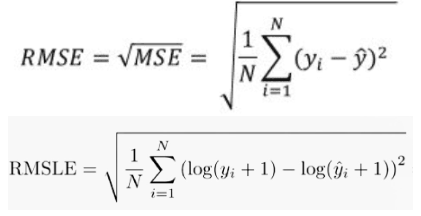
- RMSLE는 단순히 RMSE에 로그를 취한 값은 아니다. 실제값과 예측값을 모두 상용로그로 변환 한 뒤에 이를 RMSE로 적용한 것입니다.
- RMSLE에 yi 가 아니라 yi + 1을 취한 이유는 yi가 0일때 log yi가 무한대 오류가 발생하므로 +1을 한 것이다
- 일반적으로 RMSE가 아니라 RMSLE를 적용할 때는 평균보다 매우 높은 상위값들의 예측 오류 영향도가 너무 클 때 이를 상쇄하기 위해 적용합니다. 

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_train_df = train_df.drop(['value', 'name', 'continent', 'contract_until', 'position', 'prefer_foot'], axis=1, inplace=False)
y_label_df = train_df['value']

X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_label_df, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

evaluate_regr(y_val ,pred)

RMSLE: 0.985, RMSE: 3501427.934, MAE: 1946967.128, R-squared: 0.683


### LinearRrgression - One-hot

In [40]:
X_features = train.drop('value', axis=1, inplace=False)
y_label = train['value']

X_train, X_val, y_train, y_val = train_test_split(X_features, y_label, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

evaluate_regr(y_val ,pred)

RMSLE: 0.875, RMSE: 3837860.948, MAE: 1987961.364, R-squared: 0.619


### LinearRrgression - y_label(log)

In [41]:
X_features = train.drop('value', axis=1, inplace=False)
y_label = train['value']

y_label_log = np.log1p(y_label)
X_train, X_val, y_train, y_val = train_test_split(X_features, y_label_log, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

y_val_exp = np.expm1(y_val)
pred_exp = np.expm1(pred)

evaluate_regr(y_val_exp ,pred_exp)

RMSLE: 0.303, RMSE: 2566332.636, MAE: 572884.612, R-squared: 0.829


### LinearRrgression - X_features(log), y_label(log)

In [42]:
X_features = train.drop('value', axis=1, inplace=False)
y_label = train['value']

X_features_log = np.log1p(X_features)
y_label_log = np.log1p(y_label)

X_train, X_val, y_train, y_val = train_test_split(X_features_log, y_label_log, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

y_val_exp = np.expm1(y_val)
pred_exp = np.expm1(pred)

evaluate_regr(y_val_exp ,pred_exp)

RMSLE: 0.330, RMSE: 1367292.482, MAE: 553926.995, R-squared: 0.952


### LinearRrgression - 표준화

In [43]:
X_features = train.drop('value', axis=1, inplace=False)
y_label = train['value'].values.reshape(-1, 1)

X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_features_scaled = X_scaler.fit(X_features).transform(X_features)
y_label_scaled = y_scaler.fit(y_label).transform(y_label)

X_train, X_val, y_train, y_val = train_test_split(X_features_scaled, y_label_scaled, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

evaluate_regr(y_val, pred)

RMSLE: nan, RMSE: 0.657, MAE: 0.340, R-squared: 0.619


### LinearRrgression - 표준화(log)

In [44]:
from sklearn.preprocessing import StandardScaler

X_features = train.drop('value', axis=1, inplace=False)
y_label = train['value'].values.reshape(-1, 1)

X_features_log = np.log1p(X_features)
y_label_log = np.log1p(y_label)

X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_features_scaled = X_scaler.fit(X_features_log).transform(X_features_log)
y_label_scaled = y_scaler.fit(y_label_log).transform(y_label_log)

X_train, X_val, y_train, y_val = train_test_split(X_features_scaled, y_label_scaled, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

y_val_exp = np.expm1(y_val)
pred_exp = np.expm1(pred)

evaluate_regr(y_val_exp, pred_exp)

RMSLE: 0.235, RMSE: 0.484, MAE: 0.255, R-squared: 0.956


### 가장 높은 표준화(log)

In [45]:
from sklearn.preprocessing import StandardScaler

X_features = train.drop('value', axis=1, inplace=False)
y_label = train['value'].values.reshape(-1, 1)

X_features_log = np.log1p(X_features)
y_label_log = np.log1p(y_label)

X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_features_scaled = X_scaler.fit(X_features_log).transform(X_features_log)
y_label_scaled = y_scaler.fit(y_label_log).transform(y_label_log)

X_train, X_val, y_train, y_val = train_test_split(X_features_scaled, y_label_scaled, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

y_val_exp = np.expm1(y_val)
pred_exp = np.expm1(pred)

evaluate_regr(y_val_exp, pred_exp)

RMSLE: 0.235, RMSE: 0.484, MAE: 0.255, R-squared: 0.956


In [46]:
def get_model_predict(model, X_train, X_val, y_train, y_val, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    if is_expm1 :
        y_test = np.expm1(y_val)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)   

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_val, y_train, y_val, is_expm1=True)

### LinearRegression ###
RMSLE: 0.235, RMSE: 0.484, MAE: 0.255, R-squared: 0.956
### Ridge ###
RMSLE: 0.235, RMSE: 0.485, MAE: 0.256, R-squared: 0.956
### Lasso ###
RMSLE: 1.421, RMSE: 0.495, MAE: 0.266, R-squared: 0.954


In [47]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train, X_val, y_train, y_val,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 1.440, RMSE: 0.458, MAE: 0.139, R-squared: 0.961
### GradientBoostingRegressor ###
RMSLE: 1.439, RMSE: 0.411, MAE: 0.138, R-squared: 0.968
### XGBRegressor ###
RMSLE: 1.447, RMSE: 0.499, MAE: 0.158, R-squared: 0.954
### LGBMRegressor ###
RMSLE: 1.442, RMSE: 0.464, MAE: 0.141, R-squared: 0.960


### 제출 1

In [79]:
test = X_scaler.fit(test).transform(test)
pred = gbm_reg.predict(test)

In [81]:
submission = pd.read_csv('submission.csv')
submission.head()

,id,value
0,1,0
1,2,0
2,4,0
3,5,0
4,6,0


In [82]:
submission['value'] = pred
submission.to_csv('submission_1.csv', index=False)

In [83]:
submission

,id,value
0,1,3.100664
1,2,3.283372
2,4,3.249278
3,5,3.247996
4,6,3.047135
...,...,...
3823,16924,-1.981546
3824,16929,-2.131325
3825,16932,-1.986528
3826,16937,-2.056374


### LinearRrgression - X_features(log), y_label(log)

In [76]:
X_features = train.drop('value', axis=1, inplace=False)
y_label = train['value']

X_features_log = np.log1p(X_features)
y_label_log = np.log1p(y_label)

X_train, X_val, y_train, y_val = train_test_split(X_features_log, y_label_log, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

y_val_exp = np.expm1(y_val)
pred_exp = np.expm1(pred)

evaluate_regr(y_val_exp ,pred_exp)

RMSLE: 0.330, RMSE: 1367292.482, MAE: 553926.995, R-squared: 0.952


### 제출 2

In [78]:
pred = lr_reg.predict(test)
submission['value'] = pred
submission.to_csv('submission_2.csv', index=False)

### Lasso, Ridge 확인 (l1, l2 규제)

In [94]:
from sklearn.preprocessing import StandardScaler

X_features = train.drop('value', axis=1, inplace=False)
y_label = train['value'].values.reshape(-1, 1)

X_features_log = np.log1p(X_features)
y_label_log = np.log1p(y_label)

X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_features_scaled = X_scaler.fit(X_features_log).transform(X_features_log)
y_label_scaled = y_scaler.fit(y_label_log).transform(y_label_log)

X_train, X_val, y_train, y_val = train_test_split(X_features_scaled, y_label_scaled, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_val)

y_val_exp = np.expm1(y_val)
pred_exp = np.expm1(pred)

evaluate_regr(y_val_exp, pred_exp)

RMSLE: 0.235, RMSE: 0.484, MAE: 0.255, R-squared: 0.956


In [87]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alphas = [0 , 0.1 , 1 , 10 , 100]

for alpha in alphas :
    ridge = Ridge(alpha = alpha)    
    neg_mse_scores = cross_val_score(ridge, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 0.221 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 0.220 
alpha 1 일 때 5 folds 의 평균 RMSE : 0.220 
alpha 10 일 때 5 folds 의 평균 RMSE : 0.220 
alpha 100 일 때 5 folds 의 평균 RMSE : 0.221 


In [98]:
from sklearn.linear_model import Lasso

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        
        model.fit(X_data_n , y_target_n)
        coeff = pd.Series(data=model.coef_ , index=X_features.columns )
        colname='alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df

In [99]:
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_train, y_target_n=y_train)

alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 0.257 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 0.283 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 0.618 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 0.990 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 0.990 


In [95]:
ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(X_train, y_train)
test = X_scaler.fit(test).transform(test)
pred = ridge_reg.predict(test)

### 제출 3

In [96]:
submission['value'] = pred
submission.to_csv('submission_3.csv', index=False)

In [97]:
submission

,id,value
0,1,4.140018
1,2,4.198531
2,4,3.861453
3,5,3.852640
4,6,3.480027
...,...,...
3823,16924,-2.438933
3824,16929,-2.526748
3825,16932,-2.340400
3826,16937,-2.589265
